In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
future_lookup_period = 1
percent_threashold = 3
length = 90 # Length of the output sequences (in number of timesteps)

In [3]:
def import_stock_data(tickers, start_date, end_date = datetime.today()):  
    if len([tickers]) == 1:
        # Import get_history function from nsepy module
        from nsepy import get_history

        data = get_history(symbol=tickers[0],
                        start=start_date,
                        end=end_date,
                        futures=False,
                        index=True)
    return(data)

In [6]:
data = import_stock_data(['NIFTY'], start_date=datetime(2020, 1, 1), end_date=datetime(2020, 12, 31))

In [7]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,2.520000e+02
mean,11175.607540,11254.578373,11066.116468,11161.474802,6.609620e+08,3.083053e+11
std,1409.210923,1369.676080,1439.380575,1411.134117,2.007563e+08,8.475980e+10
min,7735.150000,8036.950000,7511.100000,7610.250000,1.078681e+08,5.189380e+10
25%,10116.325000,10248.750000,10039.775000,10135.650000,5.427293e+08,2.666902e+11
50%,11363.875000,11423.550000,11290.125000,11328.175000,6.319629e+08,3.080598e+11
75%,12119.250000,12155.925000,12038.275000,12091.450000,7.229381e+08,3.583619e+11
max,13980.900000,14024.850000,13936.450000,13981.950000,1.811564e+09,7.852293e+11


In [8]:
data.isnull().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Turnover    0
dtype: int64

In [9]:
data

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2020-01-01,12202.15,12222.20,12165.30,12182.50,304078039,1.044568e+11
2020-01-02,12198.55,12289.90,12195.25,12282.20,407697594,1.525655e+11
2020-01-03,12261.10,12265.60,12191.35,12226.65,428770054,1.682727e+11
2020-01-06,12170.60,12179.10,11974.20,11993.05,396501419,1.686922e+11
2020-01-07,12079.10,12152.15,12005.35,12052.95,447818617,1.779768e+11
...,...,...,...,...,...,...
2020-12-24,13672.15,13771.75,13626.90,13749.25,471367730,2.476435e+11
2020-12-28,13815.15,13885.30,13811.55,13873.20,403634030,2.092306e+11
2020-12-29,13910.35,13967.60,13859.90,13932.60,439593961,2.515423e+11


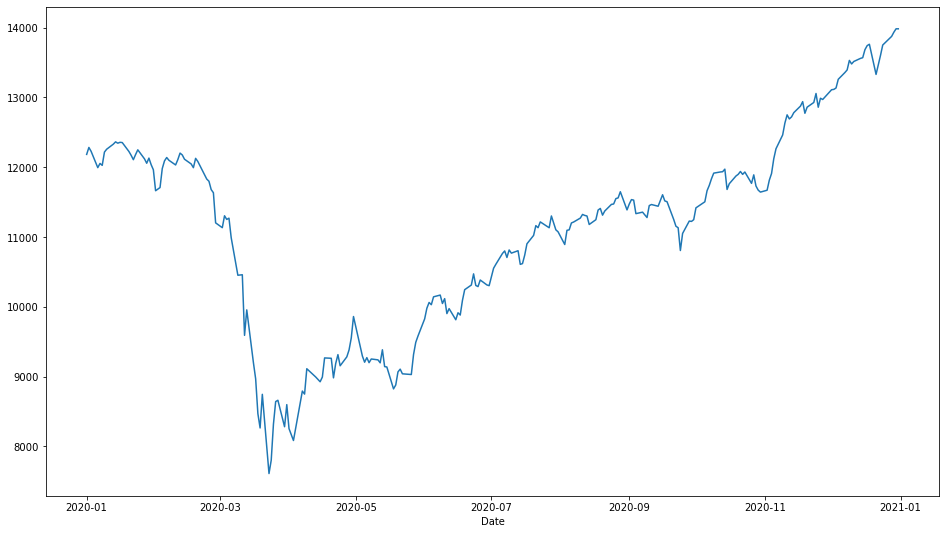

In [10]:
data['Close'].plot(figsize=(16,9))

In [11]:
data['shifted'] = data['Close'].shift(periods=-future_lookup_period)

In [12]:
data.tail(20)

,Open,High,Low,Close,Volume,Turnover,shifted
Date,,,,,,,
2020-12-03,13215.30,13216.60,13107.90,13133.90,713688035,3.962771e+11,13258.55
2020-12-04,13177.40,13280.05,13152.85,13258.55,640514315,3.642805e+11,13355.75
2020-12-07,13264.85,13366.65,13241.95,13355.75,591722966,3.357864e+11,13392.95
2020-12-08,13393.85,13435.45,13311.05,13392.95,543165361,3.375581e+11,13529.10
2020-12-09,13458.10,13548.90,13449.60,13529.10,502605319,2.872697e+11,13478.30
2020-12-10,13488.50,13503.55,13399.30,13478.30,553402501,3.040020e+11,13513.85
2020-12-11,13512.30,13579.35,13402.85,13513.85,787707481,3.369657e+11,13558.15
2020-12-14,13571.45,13597.50,13472.45,13558.15,558390043,2.813358e+11,13567.85
2020-12-15,13547.20,13589.65,13447.05,13567.85,497600393,3.082833e+11,13682.70


In [13]:
data['returns'] = ((data['shifted'] - data['Close'])/data['Close'])*100

In [14]:
data.dropna(inplace=True)

In [15]:
def return_tagger(returns):
    if returns > percent_threashold:
        return [1,0,0]
    elif returns < -percent_threashold:
        return [0,0,1]
    else:
        return [0,1,0]

In [16]:
data['y'] =  data['returns'].map(return_tagger)

In [17]:
data

,Open,High,Low,Close,Volume,Turnover,shifted,returns,y
Date,,,,,,,,,
2020-01-01,12202.15,12222.20,12165.30,12182.50,304078039,1.044568e+11,12282.20,0.818387,"[0, 1, 0]"
2020-01-02,12198.55,12289.90,12195.25,12282.20,407697594,1.525655e+11,12226.65,-0.452281,"[0, 1, 0]"
2020-01-03,12261.10,12265.60,12191.35,12226.65,428770054,1.682727e+11,11993.05,-1.910581,"[0, 1, 0]"
2020-01-06,12170.60,12179.10,11974.20,11993.05,396501419,1.686922e+11,12052.95,0.499456,"[0, 1, 0]"
2020-01-07,12079.10,12152.15,12005.35,12052.95,447818617,1.779768e+11,12025.35,-0.228990,"[0, 1, 0]"
...,...,...,...,...,...,...,...,...,...
2020-12-23,13473.50,13619.45,13432.20,13601.10,458651819,2.707345e+11,13749.25,1.089250,"[0, 1, 0]"
2020-12-24,13672.15,13771.75,13626.90,13749.25,471367730,2.476435e+11,13873.20,0.901504,"[0, 1, 0]"
2020-12-28,13815.15,13885.30,13811.55,13873.20,403634030,2.092306e+11,13932.60,0.428164,"[0, 1, 0]"


In [18]:
data.drop(columns=['Turnover', 'shifted', 'returns'], inplace = True)

In [19]:
data.head()

,Open,High,Low,Close,Volume,y
Date,,,,,,
2020-01-01,12202.15,12222.20,12165.30,12182.50,304078039,"[0, 1, 0]"
2020-01-02,12198.55,12289.90,12195.25,12282.20,407697594,"[0, 1, 0]"
2020-01-03,12261.10,12265.60,12191.35,12226.65,428770054,"[0, 1, 0]"
2020-01-06,12170.60,12179.10,11974.20,11993.05,396501419,"[0, 1, 0]"
2020-01-07,12079.10,12152.15,12005.35,12052.95,447818617,"[0, 1, 0]"


In [20]:
data['y'] = data['y'].shift(periods=1)
data.dropna(inplace=True)

In [21]:
data.tail()

,Open,High,Low,Close,Volume,y
Date,,,,,,
2020-12-23,13473.50,13619.45,13432.20,13601.10,458651819,"[0, 1, 0]"
2020-12-24,13672.15,13771.75,13626.90,13749.25,471367730,"[0, 1, 0]"
2020-12-28,13815.15,13885.30,13811.55,13873.20,403634030,"[0, 1, 0]"
2020-12-29,13910.35,13967.60,13859.90,13932.60,439593961,"[0, 1, 0]"
2020-12-30,13980.90,13997.00,13864.95,13981.95,380681073,"[0, 1, 0]"


In [22]:
import joblib
sc = joblib.load('scaler.gz')

In [23]:
training_set_scaled = sc.transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [24]:
training_set_scaled

array([[0.9854606 , 0.9992395 , 0.98940473, 1.00196182, 0.27970201],
       [0.99737205, 0.99461946, 0.98868609, 0.99148306, 0.29477286],
       [0.98013806, 0.97817366, 0.94867283, 0.94741757, 0.27169459],
       ...,
       [1.29331112, 1.30256479, 1.28723316, 1.30208255, 0.27679578],
       [1.31144013, 1.31821207, 1.2961424 , 1.31328756, 0.30251402],
       [1.32487503, 1.32380174, 1.29707294, 1.32259677, 0.26038001]])

In [25]:
# define generator
batch_size = 1 #Number of timeseries samples in each batch
stride = 1
generator = TimeseriesGenerator(training_set_scaled, data['y'].to_numpy(), length=length, batch_size=batch_size, stride=stride)

In [26]:
# What does the first batch look like?
X,y = generator[0]

In [27]:
print(f'Given the Array: \n{X}')
print(f'Predict this y: \n {y[0]}')

Given the Array: 
[[[0.9854606  0.9992395  0.98940473 1.00196182 0.27970201]
  [0.99737205 0.99461946 0.98868609 0.99148306 0.29477286]
  [0.98013806 0.97817366 0.94867283 0.94741757 0.27169459]
  [0.96271364 0.97304979 0.9544127  0.95871689 0.30839623]
  [0.93605332 0.9526684  0.94045458 0.95351053 0.30708959]
  [0.97681504 0.98671977 0.97785128 0.98945522 0.32960257]
  [0.99925732 1.00328916 0.9927123  0.99717045 0.4605957 ]
  [1.00415139 1.00833698 1.00608998 1.01089376 0.34640841]
  [1.01108308 1.01527654 1.01030966 1.01707161 0.42886452]
  [1.0141871  1.01164515 1.0047909  1.01348751 0.47756365]
  [1.01374911 1.01809039 1.01161794 1.01578888 0.27110014]
  [1.01018805 1.01740594 1.01264983 1.01519467 0.34718966]
  [1.02963104 1.02597106 0.99339408 0.99108692 0.33971498]
  [0.9848417  0.98786052 0.98333318 0.98076851 0.30564834]
  [0.98923114 0.9869099  0.96962382 0.96889384 0.36452155]
  [0.97121638 0.9800559  0.97076627 0.98274919 0.6086588 ]
  [0.98089026 0.99586478 0.98100222 0.

In [29]:
model = tf.keras.models.load_model('my_h5_model.h5')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [31]:
score = model.evaluate(generator)

160/160 [==============================] - 8s 35ms/step - loss: 0.1357 - accuracy: 0.9812


In [32]:
f'accuracy {score[1]}'

'accuracy 0.981249988079071'